# Import MNIST data set

In [54]:
import tensorflow as tf
import pickle
import os
import numpy as np
from datetime import datetime
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, SpatialDropout2D
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Data variables
x_train = None;
x_test = None;
y_train = None;
y_test = None;

# Paths
DATASET_PATH = os.path.join("datasets", "mnist");
ROOT_LOG_DIR = 'tf_logs'
MODEL_CHECKPOINTS = 'saved_models'

In [55]:
mnist = tf.keras.datasets.mnist;


def load_dataset(dataset_path=DATASET_PATH):
    global x_train, x_test, y_train, y_test
    if not os.path.isdir(dataset_path):
        os.makedirs(dataset_path)
        print('Creating folders....')
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        with open(os.path.join(dataset_path,'x_train.pickle'), 'wb') as handle:
            pickle.dump(x_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(dataset_path,'y_train.pickle'), 'wb') as handle:
            pickle.dump(y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(dataset_path,'x_test.pickle'), 'wb') as handle:
            pickle.dump(x_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(dataset_path,'y_test.pickle'), 'wb') as handle:
            pickle.dump(y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        print('Folders exist. Collecting datasets...')
        with open(os.path.join(dataset_path,'x_train.pickle'), 'rb') as handle:
            x_train= pickle.load(handle)
        with open(os.path.join(dataset_path,'y_train.pickle'), 'rb') as handle:
             y_train= pickle.load(handle)
        with open(os.path.join(dataset_path,'x_test.pickle'), 'rb') as handle:
             x_test = pickle.load(handle)
        with open(os.path.join(dataset_path,'y_test.pickle'), 'rb') as handle:
             y_test = pickle.load(handle)
    print('datasets fetched.')
load_dataset()

Folders exist. Collecting datasets...
datasets fetched.


## Visualize first six images from the Mnist data set

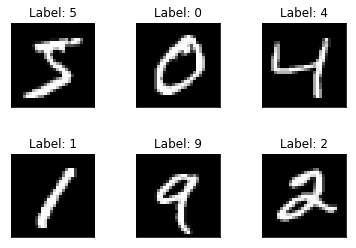

In [56]:
for i, image in enumerate(x_train[0:6]):
    first_image = image
    plt.subplot(2,3,i+1, title='Label: {0}'.format(y_train[i]), xticks=[], yticks=[])
    plt.imshow(first_image, cmap='gray')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [57]:
num_filter = 8

model = Sequential()
model.add(
        Conv2D(num_filter,
                 kernel_size=4,
                 strides=(1,1),
                 input_shape=[28,28,1],
                 padding='same',
                )
         )
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.3))
model.add(MaxPooling2D(pool_size=(2,2), padding='same', strides=(1,1)))
model.add(
        Conv2D(num_filter,
                 kernel_size=4,
                 strides=(2,2),
                 padding='same',
                )
         )
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 8)         136       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 28, 28, 8)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 8)         32        
_________________________________________________________________
spatial_dropout2d_12 (Spatia (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 8)         1032      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 14, 14, 8)         0         
__________

## Check input sample shape

In [58]:
x_train.shape

(60000, 28, 28)

In [59]:
X = x_train.reshape((60000,28,28,1))

In [60]:

Y = to_categorical(
    y_train,
    num_classes=10
)
map_test = [val for val in zip(Y[0:10],y_train[0:10])]
for val in map_test:
    print(val)


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32), 5)
(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 0)
(array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32), 4)
(array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 1)
(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32), 9)
(array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 2)
(array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 1)
(array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32), 3)
(array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 1)
(array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32), 4)


## Run the model

In [61]:
now = datetime.utcnow().strftime('%Y%m%d%H%M%S')

# CREATE MODEL CHECKPOINT
modeldir = os.path.join(MODEL_CHECKPOINTS, now)
if not os.path.isdir(modeldir):
        os.makedirs(modeldir)
model_file_path = modeldir+'/weights.hdf5'
print(model_file_path)
modelcheckpoint = ModelCheckpoint(filepath=model_file_path, verbose=1, monitor='val_loss', save_best_only=True, mode='min')



# INIT TENSORBOARD
logdir = "{}/{}".format(ROOT_LOG_DIR, now)
if not os.path.isdir(logdir):
        os.makedirs(logdir)
tensorboard = TensorBoard(log_dir=logdir)


# CREATE CALLBACK LIST
callback_list = [modelcheckpoint, tensorboard]

model.fit(X, Y, epochs=10, batch_size=32, validation_split=0.1, callbacks=[tensorboard, modelcheckpoint])

saved_models/20190217020145/weights.hdf5
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
53952/54000 [============================>.] - ETA: 0s - loss: 0.3441 - acc: 0.8947
Epoch 00001: val_loss improved from inf to 0.07716, saving model to saved_models/20190217020145/weights.hdf5
54000/54000 [==============================] - 42s 773us/step - loss: 0.3440 - acc: 0.8947 - val_loss: 0.0772 - val_acc: 0.9787
Epoch 2/10
23680/54000 [============>.................] - ETA: 22s - loss: 0.1558 - acc: 0.9522

KeyboardInterrupt: 

In [42]:
X_TEST = x_test.reshape((10000,28,28,1))
y_pred = model.predict(X_TEST)

In [43]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [44]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [45]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9828
